In [56]:
import script_utils as utils

MODEL = "custom-3"

tasks = utils.get_tasks(MODEL, remove_corrupted=True)

Removed corrupted task dir: D:\Projects\OSWorld-MA\results\pyautogui\screenshot\custom-3\chrome\06fe7178-4491-4589-810f-2e2bc9502122
Removed corrupted task dir: D:\Projects\OSWorld-MA\results\pyautogui\screenshot\custom-3\chrome\0d8b7de3-e8de-4d86-b9fd-dd2dce58a217
Removed corrupted task dir: D:\Projects\OSWorld-MA\results\pyautogui\screenshot\custom-3\libreoffice_calc\347ef137-7eeb-4c80-a3bb-0951f26a8aff
Removed corrupted task dir: D:\Projects\OSWorld-MA\results\pyautogui\screenshot\custom-3\libreoffice_calc\51719eea-10bc-4246-a428-ac7c433dd4b3
Removed corrupted task dir: D:\Projects\OSWorld-MA\results\pyautogui\screenshot\custom-3\libreoffice_calc\6054afcb-5bab-4702-90a0-b259b5d3217c
Removed corrupted task dir: D:\Projects\OSWorld-MA\results\pyautogui\screenshot\custom-3\libreoffice_calc\7a4e4bc8-922c-4c84-865c-25ba34136be1
Removed corrupted task dir: D:\Projects\OSWorld-MA\results\pyautogui\screenshot\custom-3\libreoffice_impress\04578141-1d42-4146-b9cf-6fab4ce5fd74
Removed corrupte

2026-02-01 12:42:24.995 | WARNING  | script_utils:get_tasks:70 - Warning: Only 193 tasks found, but 351 expected from ground truth.


In [30]:
count = 0
for task in tasks:
    if "error_reasons" in task and len(task["error_reasons"]) > 0:
        print(task["error_reasons"])
        break
print(count/len(tasks))

['Reasoning (Wrong Action)']
0.0


Total success rate: 68.39% (132/193)


,success_rate_%
domain,
chrome,81.395349
gimp,70.833333
libreoffice_calc,69.047619
libreoffice_writer,64.705882
libreoffice_impress,63.636364
multi_apps,55.882353


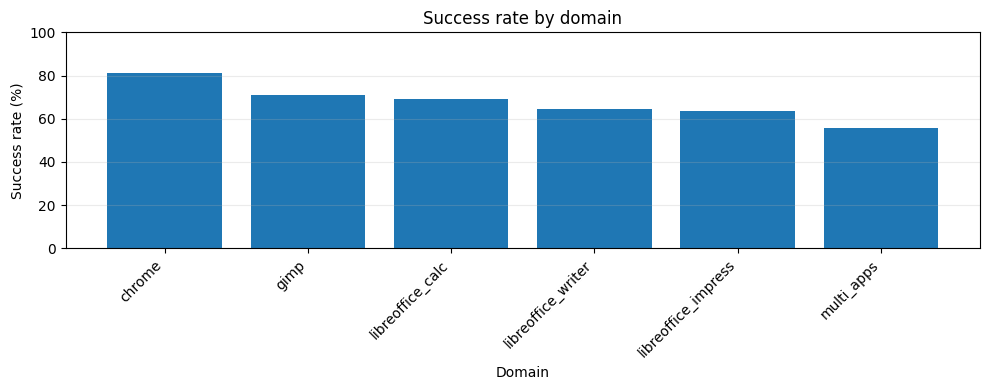

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(tasks).copy()
if df.empty:
    raise ValueError("No tasks found — run Cell 3 first.")

if "domain" not in df.columns or "success" not in df.columns:
    raise ValueError(f"Expected columns ['domain', 'success'] but got: {list(df.columns)}")

df["success_bool"] = df["success"].astype(bool)

# Total success rate (%)
total_success_rate = df["success_bool"].mean() * 100
print(f"Total success rate: {total_success_rate:.2f}% ({df['success_bool'].sum()}/{len(df)})")

# Success rate (%) by domain
success_rate = (
    df.groupby("domain")["success_bool"]
      .mean()
      .mul(100)
      .sort_values(ascending=False)
)

display(success_rate.rename("success_rate_%").to_frame())

plt.figure(figsize=(10, 4))
plt.bar(success_rate.index.astype(str), success_rate.values)
plt.ylabel("Success rate (%)")
plt.xlabel("Domain")
plt.ylim(0, 100)
plt.title("Success rate by domain")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", alpha=0.25)
plt.tight_layout()
plt.show()

In [58]:
# Define category bundles
category_mapping = {
    'os': 'OS',
    'libreoffice_calc': 'Office',
    'libreoffice_writer': 'Office',
    'libreoffice_impress': 'Office',
    'chrome': 'Daily',
    'vlc': 'Daily',
    'thunderbird': 'Daily',
    'vs_code': 'Professional',
    'gimp': 'Professional',
    'multi_apps': 'Workflow',
}

# Map domains to categories
df['category'] = df['domain'].str.lower().map(category_mapping)

# Calculate stats by category
category_stats = df.groupby('category').agg(
    total_tasks=('success_bool', 'count'),
    successful_tasks=('success_bool', 'sum'),
    success_rate=('success_bool', 'mean')
).reset_index()

category_stats['success_rate'] = (category_stats['success_rate'] * 100).round(2)
category_stats = category_stats.sort_values('success_rate', ascending=False)

# Add totals row
totals = pd.DataFrame({
    'category': ['TOTAL'],
    'total_tasks': [df['success_bool'].count()],
    'successful_tasks': [df['success_bool'].sum()],
    'success_rate': [round(df['success_bool'].mean() * 100, 2)]
})
category_stats = pd.concat([category_stats, totals], ignore_index=True)

# Display the table
category_stats.columns = ['Category', 'Total Tasks', 'Successful', 'Success Rate (%)']
display(category_stats)

,Category,Total Tasks,Successful,Success Rate (%)
0,Daily,43,35,81.40
1,Professional,24,17,70.83
2,Office,92,61,66.30
3,Workflow,34,19,55.88
4,TOTAL,193,132,68.39


In [80]:
all_error_reasons = []
for task in tasks:
    error_reasons = task.get("error_reasons", [])
    if len(error_reasons) > 0:
        if "Limit Reached" not in error_reasons and len(error_reasons) >= 50:
            error_reasons.append("Limit Reached")
        all_error_reasons.append(error_reasons)

In [81]:
error_map = {}
for reasons in all_error_reasons:
    for reason in reasons:
        if reason not in error_map:
            error_map[reason] = 0
        error_map[reason] += 1
error_map

{'Task Incompleteness': 6,
 'Reasoning (Wrong Action)': 25,
 'UI Comprehension': 28,
 'Task Ambiguity / Misunderstanding': 1,
 'Knowledge': 23,
 'Looping / Repetition': 6,
 'Infeasible': 11,
 'Hallucinated Action': 10,
 'Localization': 12,
 'Limit Reached': 30}

In [41]:
input_tokens, cached_input_tokens, output_tokens = 0, 0, 0
for task in tasks:
    trajs = task.get("trajectories", [])
    for traj in trajs:
        usage = traj["usage"]
        input_tokens += usage["input_tokens"]
        cached_input_tokens += usage.get("cached_input_tokens", 0)
        output_tokens += usage["output_tokens"]

In [ ]:
input_tokens, cached_input_tokens, output_tokens = 0, 0, 0
for task in tasks:
    input_tokens += task["usage_input_tokens"]
    cached_input_tokens += task["usage_cached_input_tokens"]
    output_tokens += task["usage_output_tokens"]

In [42]:
print(f"Input tokens: {input_tokens}")
print(f"Cached input tokens: {cached_input_tokens}")
print(f"Output tokens: {output_tokens}")

Input tokens: 12144039
Cached input tokens: 5378432
Output tokens: 701092


In [30]:
steps = sum(task["steps"] for task in tasks)
print(f"Total steps: {steps}")

Total steps: 1281


In [31]:
avg_steps = steps / len(tasks) if tasks else 0
print(f"Average steps per task: {avg_steps:.2f}")

Average steps per task: 14.56


In [96]:
time = steps * 15  # assuming each step takes 10 seconds
time += output_tokens / 77  # assuming each token takes 1/77 seconds
time

159707.2987012987

In [97]:
steps * 15

132360

In [23]:
time_per_task = time / len(tasks) if tasks else 0
time_per_task

NameError: name 'time' is not defined

In [ ]:
t = None
for task in tasks:
    if task["domain"] == "gimp":
        if task["task_id"] == "2a729ded-3296-423d-aec4-7dd55ed5fbb3":
            t = task

In [55]:
for traj in t["trajectories"]:
    usage = traj["usage"]
    print(usage)

{'input_tokens': 5869, 'output_tokens': 438, 'cached_input_tokens': 1408}
{'input_tokens': 7762, 'output_tokens': 921, 'cached_input_tokens': 1408}
{'input_tokens': 8098, 'output_tokens': 298, 'cached_input_tokens': 3072}
{'input_tokens': 5258, 'output_tokens': 508, 'cached_input_tokens': 7808}
{'input_tokens': 11889, 'output_tokens': 129, 'cached_input_tokens': 3072}
{'input_tokens': 9709, 'output_tokens': 362, 'cached_input_tokens': 3072}
{'input_tokens': 12022, 'output_tokens': 130, 'cached_input_tokens': 3072}
{'input_tokens': 13765, 'output_tokens': 316, 'cached_input_tokens': 1408}
{'input_tokens': 12053, 'output_tokens': 461, 'cached_input_tokens': 3200}
{'input_tokens': 12265, 'output_tokens': 835, 'cached_input_tokens': 3072}
{'input_tokens': 9711, 'output_tokens': 460, 'cached_input_tokens': 3456}
{'input_tokens': 12153, 'output_tokens': 820, 'cached_input_tokens': 3328}
{'input_tokens': 12109, 'output_tokens': 862, 'cached_input_tokens': 3456}
{'input_tokens': 11940, 'output